# Homework 2

The goal of this assignment was to predict the market rate for apartments' rent based on 2014 Census data (https://www.census.gov/housing/nychvs/data/2014/userinfo2.html).

This is an updated version of the original submission.

### Import Libraries, Load Data

In [1]:
import urllib.request
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, PolynomialFeatures
from sklearn.linear_model import Lasso, Ridge, LinearRegression, LassoCV, RidgeCV
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
url = 'https://ndownloader.figshare.com/files/7586326'
response = urllib.request.urlopen(url)
lines = response.readlines()
data = pd.DataFrame(np.genfromtxt(lines, delimiter=",", names=True, dtype=None))

### Prepare Data

##### Data Cleaning

Column 'uf17' is the response variable (rent). First, we remove any rows in which the response variable is unknown (encoded as 99999). Then, we set y to be this column.

In [3]:
data = data.loc[data['uf17'] != 99999]

In [4]:
y = pd.DataFrame(data)['uf17']

Next, we remove a number of features that are too specific to the current tenant, or are leaky.

In [5]:
drop_cols = ['recid', 'hhr2', 'uf43', 'hhr5', 'race1', 'uf2a', 'uf2b', 'sc51', 'sc52', 'sc53', 'sc54', 'sc110', 
             'sc111', 'sc112', 'sc113', 'sc117', 'sc140', 'sc184', 'sc542', 'sc543', 'sc544', 'sc548', 'sc549', 
             'sc550', 'sc551', 'sc570', 'sc574', 'sc560', 'uf53', 'uf54', 'new_csr', 'rec1', 'uf46', 'rec4', 
             'rec_race_a', 'rec_race_c', 'tot_per', 'rec28', 'rec39', 'uf42', 'uf42a', 'uf34', 'uf34a', 'uf35', 
             'uf35a', 'uf36', 'uf36a', 'uf37', 'uf37a', 'uf38', 'uf38a', 'uf39', 'uf39a', 'uf40', 'uf40a', 'uf30', 
             'uf29', 'rec8', 'rec7', 'fw', 'chufw', 'flg_sx1', 'flg_ag1', 'flg_hs1', 'flg_rc1', 'hflag2', 'hflag1', 
             'hflag18', 'uf52h_h', 'uf52h_a', 'uf52h_b', 'uf52h_c', 'uf52h_d', 'uf52h_e', 'uf52h_f', 'uf52h_g', 
             'sc115', 'sc116', 'uf5', 'sc125', 'sc143', 'sc174', 'uf64', 'uf17', 'uf17a', 'sc181', 'sc541', 'sc27', 
             'sc152', 'sc153', 'sc155', 'sc156', 'uf26', 'uf28', 'uf27', 'seqno', 'hflag13', 'hflag6', 'hflag3', 
             'hflag14', 'hflag16', 'hflag7', 'hflag9', 'hflag10', 'hflag91', 'hflag11', 'hflag12', 'hflag4', 'uf6', 
             'uf7']

In [6]:
data = data.drop(drop_cols, axis=1)

In [7]:
data.head()

,boro,uf1_1,uf1_2,uf1_3,uf1_4,uf1_5,uf1_6,uf1_7,uf1_8,uf1_9,...,uf19,rec15,sc26,uf23,rec21,rec62,rec64,rec54,rec53,cd
3,1,9,9,9,9,1,9,9,9,9,...,2,13,16,2,1,1,1,1,1,1
5,1,9,9,9,9,1,9,9,9,9,...,2,3,16,8,1,1,1,1,1,1
10,1,9,9,9,9,1,9,9,9,9,...,2,1,16,9,1,2,2,1,1,1
11,1,9,9,9,9,1,9,9,9,9,...,2,1,16,9,1,1,1,2,2,1
14,1,9,9,9,9,1,9,9,9,9,...,2,5,16,7,1,1,1,1,1,1


Now we look at missing data in each column. The 'na_vals' dictionary contains all values encoding missing data for each feature. Features not appearing in this dictionary do not have such a value.

If more than 50% of the column is missing, we remove it from our analysis. Otherwise, we replace the corresponding missing value with NA.

In [8]:
na_vals = {
    'uf1_1': [8], 
    'uf1_2': [8], 
    'uf1_3': [8], 
    'uf1_4': [8], 
    'uf1_5': [8], 
    'uf1_6': [8], 
    'uf1_7': [8],
    'uf1_8': [8], 
    'uf1_9': [8], 
    'uf1_10': [8], 
    'uf1_11': [8], 
    'uf1_12': [8], 
    'uf1_13': [8], 
    'uf1_14': [8],
    'uf1_15': [8], 
    'uf1_16': [8], 
    'uf1_35': [8], 
    'uf1_17': [8], 
    'uf1_18': [8], 
    'uf1_19': [8], 
    'uf1_20': [8],
    'uf1_21': [8], 
    'uf1_22': [8], 
    'sc23': [8], 
    'sc24': [8], 
    'sc36': [8], 
    'sc37': [8], 
    'sc38': [8], 
    'sc114': [4],
    'sc118': [3, 8, 9], 
    'sc120': [9], 
    'sc121': [9], 
    'sc127': [9], 
    'sc134': [9999], 
    'uf7a': [9999], 
    'uf9': [99], 
    'sc141': [9],
    'uf8': [9999], 
    'sc144': [9], 
    'uf10': [99], 
    'sc147': [3, 8], 
    'sc173': [8, 9],
    'sc171': [3, 8], 
    'sc154': [8, 9], 
    'sc157': [8, 9], 
    'uf12': [9999],
    'uf13': [9999], 
    'uf14': [9999], 
    'uf15': [9999], 
    'uf16': [99999], 
    'sc197': [4, 8], 
    'sc198': [8], 
    'sc187': [8], 
    'sc188': [8], 
    'sc571': [5, 8], 
    'sc189': [5, 8], 
    'sc190': [8],
    'sc191': [8], 
    'sc192': [8], 
    'sc193': [8, 9], 
    'sc194': [8], 
    'sc196': [8], 
    'sc199': [8], 
    'sc575': [8], 
    'rec15': [8, 10, 12], 
    'rec21': [8], 
    'rec54': [7], 
    'rec53': [7]
}

In [9]:
def replace_remove_missing(data, col_name, na_vals):
    column = data[col_name]
    print('Column: {}'.format(col_name))
    
    counts = column.value_counts()
    values = na_vals[col_name]
    missing_total = 0
    for val in values:
        if counts[val]:
            missing_total += counts[val]
    missing = missing_total / len(data)
    print('Percent missing: {}'.format(missing*100))
    
    if missing > 0.5:
        data.drop(col_name, axis=1, inplace=True)
        print('Column removed')
    else:
        data[col_name].replace(to_replace=na_vals, value=np.nan, inplace=True)
        print('NA values replaced')

In [10]:
for col in na_vals.keys():
    replace_remove_missing(data, col, na_vals)

Column: sc157
Percent missing: 9.531723531136963
NA values replaced
Column: uf1_16
Percent missing: 3.7149281454687655
NA values replaced
Column: uf1_15
Percent missing: 3.7149281454687655
NA values replaced
Column: uf14
Percent missing: 79.47991005963438
Column removed
Column: uf8
Percent missing: 100.0
Column removed
Column: uf1_20
Percent missing: 1.2024635839280478
NA values replaced
Column: rec53
Percent missing: 1.1340306970378335
NA values replaced
Column: sc127
Percent missing: 100.0
Column removed
Column: uf1_19
Percent missing: 1.2024635839280478
NA values replaced
Column: uf1_14
Percent missing: 3.7149281454687655
NA values replaced
Column: uf1_11
Percent missing: 0.7429856290937531
NA values replaced
Column: uf1_7
Percent missing: 0.7429856290937531
NA values replaced
Column: uf1_4
Percent missing: 0.4888063349301007
NA values replaced
Column: uf1_6
Percent missing: 0.4888063349301007
NA values replaced
Column: uf7a
Percent missing: 100.0
Column removed
Column: uf13
Percent

##### Train-Test Split

The next step is to split the X and y dataset into train and test data.

In [11]:
X_train, X_test, y_train, y_test = train_test_split(data, y, random_state=42)

In [12]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(7671, 70)
(2558, 70)
(7671,)
(2558,)


In [13]:
X_train.head()

,boro,uf1_1,uf1_2,uf1_3,uf1_4,uf1_5,uf1_6,uf1_7,uf1_8,uf1_9,...,uf19,rec15,sc26,uf23,rec21,rec62,rec64,rec54,rec53,cd
1460,1,9,9,9,9,1,9,9,9,9,...,2,3,12,6,1,1,1,2,3,7
6352,2,9,9,9,9,1,9,9,9,9,...,2,3,12,6,1,1,1,7,9,18
8395,3,9,9,9,9,1,9,9,9,9,...,1,5,16,9,8,1,1,1,1,5
5214,2,9,9,9,9,1,9,9,9,9,...,1,3,16,7,1,1,1,1,2,14
12424,4,9,9,9,9,1,9,9,9,9,...,2,13,16,2,1,1,1,1,1,7


##### Imputation

Next, we use K-Nearest Neighbors with the 'boro' variable, for which no rows are missing, to impute missing data.

In [14]:
X_train_knn = np.array(X_train)
X_test_knn = np.array(X_test)

In [15]:
def knn_impute(X_train, X_test, column, continuous=False):
    missing_train = np.isnan(X_train_knn[:, column])
    missing_test = np.isnan(X_test_knn[:, column])
    
    if continuous:
        knn = KNeighborsRegressor()
    else:
        knn = KNeighborsClassifier()
    
    if sum(missing_train) > 0:
        knn.fit(X_train_knn[~missing_train,0].reshape(-1,1), X_train_knn[~missing_train, column])
        X_train_knn[missing_train, column] = knn.predict(X_train_knn[missing_train, 0].reshape(-1,1))
    
    if sum(missing_test) > 0:
        X_test_knn[missing_train, column] = knn.predict(X_test_knn[missing_train, 0].reshape(-1,1))

In [16]:
continuous_cols = ['sc150', 'sc151', 'uf12']

In [17]:
for col in range(1, X_train_knn.shape[1]):
    if X_train.columns[col] in continuous_cols:
        knn_impute(X_train, X_test, col, continuous=True)
    else:
        knn_impute(X_train, X_test, col)

In [18]:
X_train_knn = pd.DataFrame(X_train_knn, columns=X_train.columns)
X_test_knn = pd.DataFrame(X_test_knn, columns=X_test.columns)

In [19]:
X_train_knn.head()

,boro,uf1_1,uf1_2,uf1_3,uf1_4,uf1_5,uf1_6,uf1_7,uf1_8,uf1_9,...,uf19,rec15,sc26,uf23,rec21,rec62,rec64,rec54,rec53,cd
0,1,9,9,9,9,1,9,9,9,9,...,2,3,12,6,1,1,1,2,3,7
1,2,9,9,9,9,1,9,9,9,9,...,2,3,12,6,1,1,1,7,9,18
2,3,9,9,9,9,1,9,9,9,9,...,1,5,16,9,8,1,1,1,1,5
3,2,9,9,9,9,1,9,9,9,9,...,1,3,16,7,1,1,1,1,2,14
4,4,9,9,9,9,1,9,9,9,9,...,2,13,16,2,1,1,1,1,1,7


##### Scaling

Here, we scale the continuous features to mean 0 and standard deviation 1.

In [20]:
X_train_scaled = X_train_knn.copy()
X_test_scaled = X_test_knn.copy()

In [21]:
for col in continuous_cols:
    scaler = StandardScaler()
    X_train_scaled[col] = scaler.fit_transform(X_train_knn[col])
    X_test_scaled[col] = scaler.transform(X_test_knn[col])

/Users/stephaniedoctor/anaconda/envs/py3k/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)
/Users/stephaniedoctor/anaconda/envs/py3k/lib/python3.5/site-packages/sklearn/preprocessing/data.py:586: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Users/stephaniedoctor/anaconda/envs/py3k/lib/python3.5/site-packages/sklearn/preprocessing/data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(D

In [22]:
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

In [23]:
X_train_scaled.head()

,boro,uf1_1,uf1_2,uf1_3,uf1_4,uf1_5,uf1_6,uf1_7,uf1_8,uf1_9,...,uf19,rec15,sc26,uf23,rec21,rec62,rec64,rec54,rec53,cd
0,1,9,9,9,9,1,9,9,9,9,...,2,3,12,6,1,1,1,2,3,7
1,2,9,9,9,9,1,9,9,9,9,...,2,3,12,6,1,1,1,7,9,18
2,3,9,9,9,9,1,9,9,9,9,...,1,5,16,9,8,1,1,1,1,5
3,2,9,9,9,9,1,9,9,9,9,...,1,3,16,7,1,1,1,1,2,14
4,4,9,9,9,9,1,9,9,9,9,...,2,13,16,2,1,1,1,1,1,7


##### One-Hot Encoding

Finally, we perform label encoding and then one-hot encoding on the categorical variables.

In [24]:
X_train_le = X_train_scaled.copy()
X_test_le = X_test_scaled.copy()

In [25]:
le = LabelEncoder()
for col in X_train.columns:
    if col in continuous_cols:
        continue
    X_train_le[col] = le.fit_transform(X_train_le[col])
    X_test_le[col] = le.transform(X_test_le[col])

In [26]:
cat_mask = [x not in continuous_cols for x in X_train.columns.tolist()]

In [27]:
onehot = OneHotEncoder(categorical_features=cat_mask)
X_train_onehot = onehot.fit_transform(np.array(X_train_le))
X_test_onehot = onehot.transform(np.array(X_test_le))

In [28]:
X_train_onehot = pd.DataFrame(X_train_onehot.toarray())
X_test_onehot = pd.DataFrame(X_test_onehot.toarray())

In [29]:
X_train_onehot.head()

,0,1,2,3,4,5,6,7,8,9,...,281,282,283,284,285,286,287,288,289,290
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.199796,1.475622,1.245331
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.420751,0.412159,1.245331
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.137338,-0.651303,1.245331
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.358294,-0.651303,-0.809704
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.978840,1.475622,1.245331


### Initial Models

Now we are ready to try regression algorithms to predict rent based on the features we have prepared. First, we try Linear Regression, Ridge Regression, and LASSO without tuning any hyperparameters.

##### Linear Regression

In [30]:
linear = LinearRegression()
linear.fit(X_train_onehot, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [31]:
print('Training score: {}'.format(linear.score(X_train_onehot, y_train)))
print('Test score: {}'.format(linear.score(X_test_onehot, y_test)))

Training score: 0.48190351715320157
Test score: 0.42978824029328594


##### Ridge Regression

In [32]:
ridge = Ridge()
ridge.fit(X_train_onehot, y_train)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [33]:
print('Training score: {}'.format(ridge.score(X_train_onehot, y_train)))
print('Test score: {}'.format(ridge.score(X_test_onehot, y_test)))

Training score: 0.480449250793068
Test score: 0.4308351596791935


##### LASSO

In [34]:
lasso = Lasso()
lasso.fit(X_train_onehot, y_train)

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [35]:
print('Training score: {}'.format(lasso.score(X_train_onehot, y_train)))
print('Test score: {}'.format(lasso.score(X_test_onehot, y_test)))

Training score: 0.47335986261889595
Test score: 0.43245229493341647


Among initial models, LASSO scores best, with Ridge and Linear Regression close behind.

### Models with Grid Search

To try to improve the Ridge and LASSO models, we grid-search their alpha parameters.

##### Ridge Regression

In [36]:
grid_ridge = RidgeCV(alphas=[0.0001, 0.001, 0.01, 0.1, 1.0, 10])
grid_ridge.fit(X_train_onehot,y_train)

RidgeCV(alphas=[0.0001, 0.001, 0.01, 0.1, 1.0, 10], cv=None,
    fit_intercept=True, gcv_mode=None, normalize=False, scoring=None,
    store_cv_values=False)

In [37]:
print('Alpha: {}'.format(grid_ridge.alpha_))
print('Training score: {}'.format(grid_ridge.score(X_train_onehot, y_train)))
print('Test score: {}'.format(grid_ridge.score(X_test_onehot, y_test)))

Alpha: 0.01
Training score: 0.4824768527513389
Test score: 0.43211259226371357


##### LASSO

In [38]:
grid_lasso = LassoCV(eps=1e-5, n_alphas=6, max_iter=1e6, cv=10)
grid_lasso.fit(X_train_onehot, y_train)

LassoCV(alphas=None, copy_X=True, cv=10, eps=1e-05, fit_intercept=True,
    max_iter=1000000.0, n_alphas=6, n_jobs=1, normalize=False,
    positive=False, precompute='auto', random_state=None,
    selection='cyclic', tol=0.0001, verbose=False)

In [39]:
print('Alpha: {}'.format(grid_lasso.alpha_))
print('Training score: {}'.format(grid_lasso.score(X_train_onehot, y_train)))
print('Test score: {}'.format(grid_lasso.score(X_test_onehot, y_test)))

Alpha: 0.015063808145643466
Training score: 0.4824579905601829
Test score: 0.43238766472111956


After grid-searching, the test score of Ridge improved slightly. LASSO's score stayed about the same but remains the best of the three models, at about 43%.

### Plotting the Models' Results

In [41]:
linear_pred = linear.predict(X_test_onehot)
ridge_pred = grid_ridge.predict(X_test_onehot)
lasso_pred = grid_lasso.predict(X_test_onehot)

In [43]:
predictions = pd.DataFrame({'y': y_test,
                           'linear': linear_pred,
                           'ridge': ridge_pred,
                           'lasso': lasso_pred})
predictions_sorted = predictions.sort(columns='y')

/Users/stephaniedoctor/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:5: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


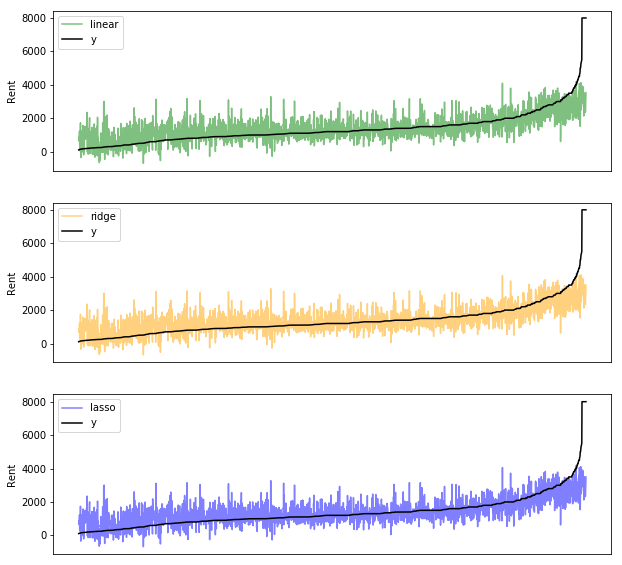

In [60]:
fig, ax = plt.subplots(3, sharey=True, figsize=(10,10))

ax[0].plot(range(len(predictions)), predictions_sorted['linear'], c='green', alpha=0.5)
ax[1].plot(range(len(predictions)), predictions_sorted['ridge'], c='orange', alpha=0.5)
ax[2].plot(range(len(predictions)), predictions_sorted['lasso'], c='blue', alpha=0.5)

for k in range(3):
    ax[k].plot(range(len(predictions)), predictions_sorted['y'], c='black')
    ax[k].set_ylabel('Rent')
    ax[k].legend()
    ax[k].set_xticks([])
    
plt.show()

Ultimately, all three models had very similar results, even down to specific observations. Additionally, all three models performed best in the mid-range rent values, failed completely to capture the very high rent values, and underperformed on the very low rents.